# Pets Identification with PyGMData


PyGMData Documentation: https://pygmdata.readthedocs.io/en/latest/

Local deployment of GM Data: http://ursula:8181/static/ui/index.html

In [1]:
from fastai.vision.all import *

In [2]:
import pygmdata.pygmdata as gm

In [3]:
DATA_DIR = '/home/hiromi.suenaga@greymatter.io/pets/dataset'
workpath = Path('/home/hiromi.suenaga/git/pets/')

### pygmdata

In [4]:
gmdata = gm.Data("http://ursula:8181", USER_DN='CN=hiromi.suenaga,OU=Engineering,O=Decipher Technology Studios,L=Alexandria,ST=Virginia,C=US')

In [5]:
gmdata.repopulate = False

### Upload to gm-data

In [6]:
# modelpath = workpath/'model'
# path = untar_data(URLs.PETS)

In [7]:
# files = get_image_files(path/"images")
# len(files)

In [8]:
# for file in files:
#     data.upload_file(str(file), f'{DATA_DIR}/{file.name}')

Above block took 1h 0m 39s

### PyGmData Dataset

In [9]:
def get_gm_img_files(folder):
    images = []
    files = gmdata.get_list(folder)
    for f in files:
        if f['mimetype'] == 'image/jpeg':
            images.append(f'{folder}/{f["name"]}')
    return images

In [10]:
image_files = get_gm_img_files(DATA_DIR)

In [11]:
def gm_load_image(fn, mode=None):
    im = gmdata.stream_file(fn)
    im.load()
    im = im._new(im.im)
    return im.convert(mode) if mode else im

In [12]:
class GMPILImage(PILImage):
    @classmethod
    def create(cls, fn:(str), **kwargs)->None:
        return PILImage(gm_load_image(fn, **merge(cls._open_args, kwargs)))

In [13]:
pets = DataBlock(blocks = (ImageBlock(cls=GMPILImage),CategoryBlock),
                 get_items = get_gm_img_files,
                 splitter=RandomSplitter(),
                 get_y = RegexLabeller(r'([^/]*)_\d+.jpg'),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())

In [14]:
dls = pets.dataloaders(DATA_DIR)

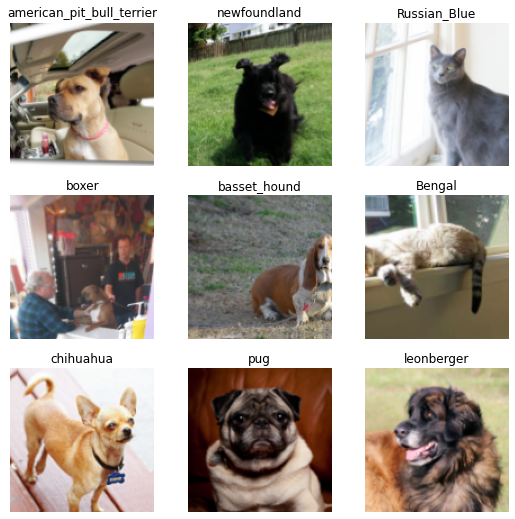

In [15]:
dls.show_batch(max_n=9)

### Create a learner 

In [16]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

## Training

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0063095735386013985)

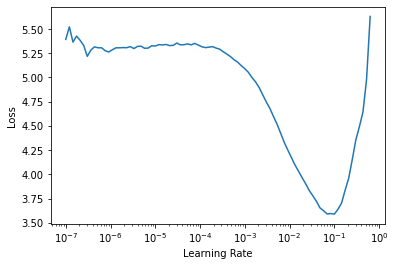

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(8, 3e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.462196,1.737537,0.412043,0.587957,00:56
1,2.005938,1.524983,0.416103,0.583897,00:56
2,1.327086,1.161797,0.339648,0.660352,00:36
3,1.092268,1.123660,0.336265,0.663735,00:36
4,0.930811,0.803524,0.253045,0.746955,00:36
5,0.727385,0.580983,0.181326,0.818674,00:36
6,0.568025,0.486707,0.154939,0.845061,00:36
7,0.447768,0.482197,0.154939,0.845061,00:37


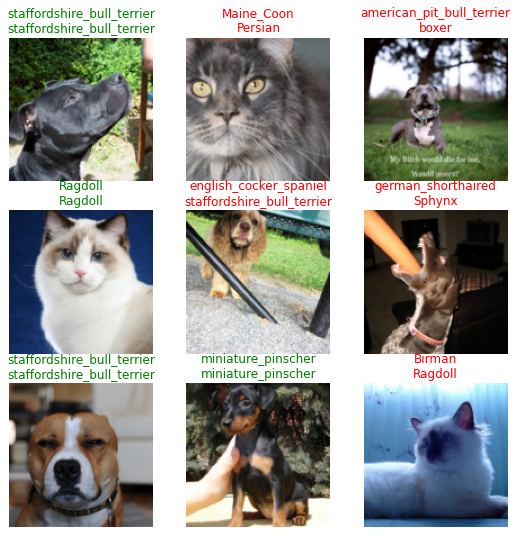

In [19]:
learn.show_results()

In [20]:
interp = Interpretation.from_learner(learn)


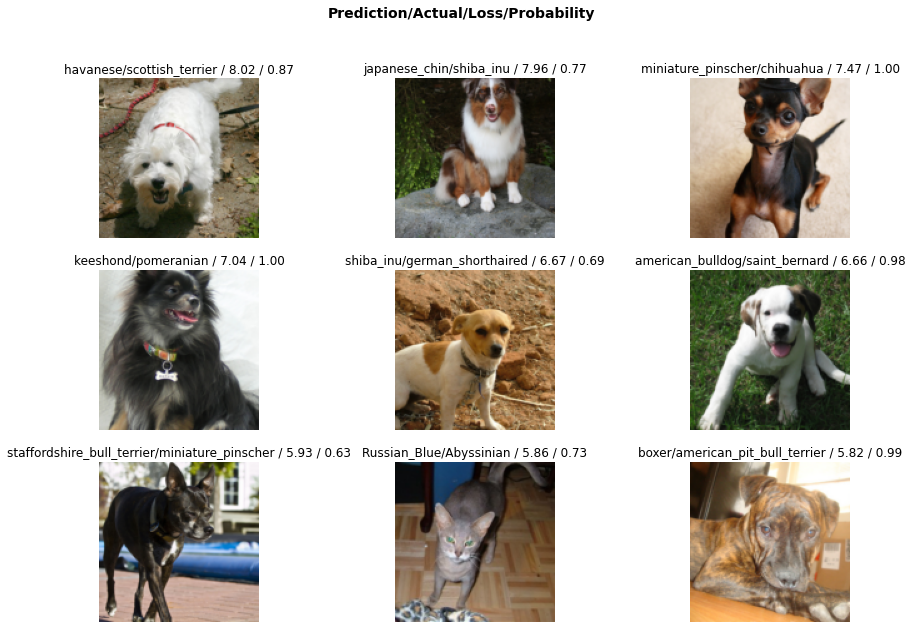

In [21]:
interp.plot_top_losses(9, figsize=(15,10))

In [22]:
file = learn.save(workpath/'model/gm_model')

In [23]:
gmdata.upload_file(str(file), f'/home/hiromi.suenaga@greymatter.io/pets/model/gm_model.pth', mimetype='application')

True

## Predicting

In [24]:
learn.load(gmdata.stream_file('/home/hiromi.suenaga@greymatter.io/pets/model/gm_model.pth'))

In [25]:
pic1 = gmdata.stream_file('/home/hiromi.suenaga@greymatter.io/pets/examples/1.jpg')
pic2 = gmdata.stream_file('/home/hiromi.suenaga@greymatter.io/pets/examples/2.jpg')

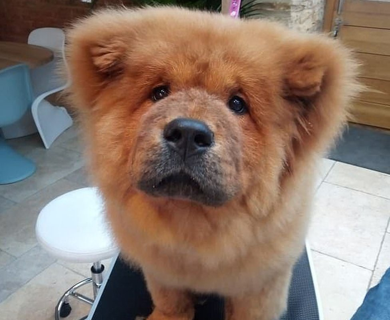

In [26]:
pic1.resize([390, 320])

In [27]:
label, _, _ = learn.predict('/home/hiromi.suenaga@greymatter.io/pets/examples/1.jpg')
label

'pomeranian'

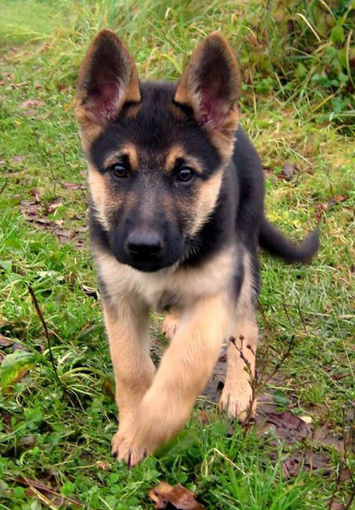

In [28]:
pic2.resize([355,510])

In [29]:
label, _, _ = learn.predict('/home/hiromi.suenaga@greymatter.io/pets/examples/2.jpg')
label

'shiba_inu'